In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

class Option_Strategy:
    def __init__(self, data):
        self.data = data
        self.S = data['close'].values
        self.T = data['time'].values
        self.V = data['volume'].values
        
    def calculate_returns(self):
        self.returns = np.log(self.S[1:] / self.S[:-1])
        
    def calculate_volatility(self, window=30):
        returns_series = pd.Series(self.returns)
        self.volatility = returns_series.rolling(window=window).std().values * np.sqrt(252)
        
    def black_scholes(self, K, r, t, sigma, option_type='call'):
        # Ensure sigma has the same length as S by padding with NaN
        sigma_padded = np.pad(sigma, (1, 0), mode='constant', constant_values=np.nan)
        
        d1 = (np.log(self.S / K) + (r + 0.5 * sigma_padded**2) * t) / (sigma_padded * np.sqrt(t))
        d2 = d1 - sigma_padded * np.sqrt(t)
        
        if option_type == 'call':
            option_price = self.S * norm.cdf(d1) - K * np.exp(-r * t) * norm.cdf(d2)
        elif option_type == 'put':
            option_price = K * np.exp(-r * t) * norm.cdf(-d2) - self.S * norm.cdf(-d1)
        
        return option_price
    
    def plot_results(self):
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 15))
        
        ax1.plot(self.T, self.S)
        ax1.set_title('Asset Price')
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Price')
        
        ax2.plot(self.T[1:], self.volatility)
        ax2.set_title('Volatility')
        ax2.set_xlabel('Time')
        ax2.set_ylabel('Volatility')
        
        ax3.plot(self.T, self.option_price)
        ax3.set_title('Option Price')
        ax3.set_xlabel('Time')
        ax3.set_ylabel('Price')
        
        plt.tight_layout()
        plt.show()
    
    def generate_feedback(self):
        avg_vol = np.nanmean(self.volatility)
        current_price = self.S[-1]
        current_option_price = self.option_price[-1]
        
        feedback = f"Current asset price: ${current_price:.2f}\n"
        feedback += f"Current option price: ${current_option_price:.2f}\n"
        feedback += f"Average volatility: {avg_vol:.2%}\n"
        
        if avg_vol > 0.3:
            feedback += "High volatility detected. Consider using strategies that benefit from volatility.\n"
        else:
            feedback += "Low to moderate volatility. Consider more directional strategies.\n"
        
        return feedback
    
    def run_analysis(self, K, r, t, option_type='call'):
        self.calculate_returns()
        self.calculate_volatility()
        self.option_price = self.black_scholes(K, r, t, self.volatility, option_type)
        self.plot_results()
        print(self.generate_feedback())

In [21]:
# get /Users/andrewdiedrich/Downloads/Kraken_OHLCVT/SOLUSD_1440.csv
data = pd.read_csv('../../../Kraken_OHLCVT/SOLUSD_1440.csv')
# assign column names
data.columns = ['time', 'open', 'high', 'low', 'close', 'volume', 'trades']
data['time'] = pd.to_datetime(data['time'])
data = data.sort_values('time')
data = data.reset_index(drop=True)
# transform close and volume to float
data['close'] = data['close'].astype(float)
data['volume'] = data['volume'].astype(float)
data['time'] = data['time'].astype(str)
data = data.dropna()

print(data.head())


                            time   open   high    low  close        volume  \
0  1970-01-01 00:00:01.623974400  39.14  39.36  35.00  36.62  13557.357196   
1  1970-01-01 00:00:01.624060800  36.82  37.35  35.00  35.45  16986.163716   
2  1970-01-01 00:00:01.624147200  35.09  35.89  31.48  35.28  38681.265775   
3  1970-01-01 00:00:01.624233600  35.08  35.08  26.00  26.55  41903.613224   
4  1970-01-01 00:00:01.624320000  26.43  28.69  20.20  26.18  43706.219980   

   trades  
0     526  
1     574  
2    1229  
3    1588  
4    1716  


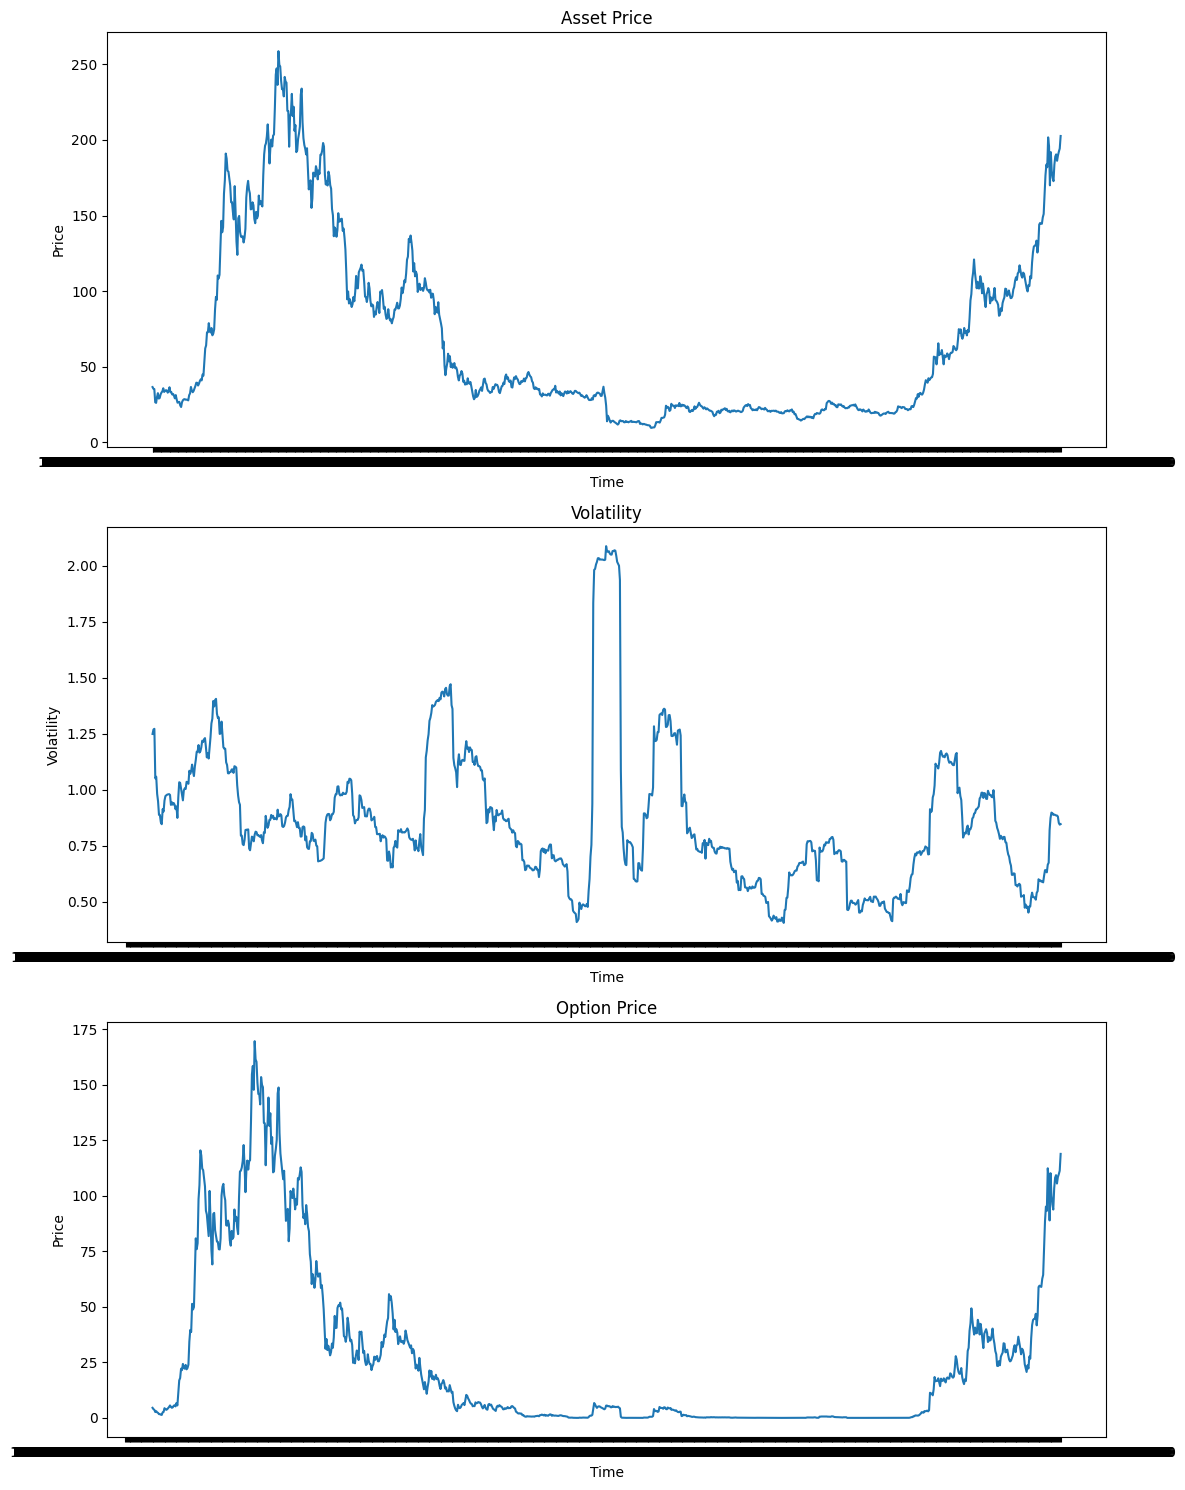

Current asset price: $202.60
Current option price: $118.81
Average volatility: 86.05%
High volatility detected. Consider using strategies that benefit from volatility.



In [22]:
strategy = Option_Strategy(data)
strategy.run_analysis(K=100, r=0.05, t=1, option_type='call')